# Postie TakeHome
Jixiong Han

### Disclaimer:

For the purpose of this exercise, the author want to limit the time spent to several hours. There is definitely more work could be done on data processing, feature engineering, pattern discovery and ML models development etc. But since we want to limit the time spent so the scope of this work is also limited.

Also for the same purpose, the author didn't spend a lot time to make the report/charts super appealing or tidy. In the real world situation, extra effort will be spent to improve the quality of the final report.

## Contents

### 1. Goal: 

### 2. Import packages and data

### 3. Why sale of 07-03 is lower 

### 4. More analysis on sale, customer, purchasing behavior

### 5. Prediction of 07-04 sale value

### 6. Final words

### 1. Goal: 
There are several goals for this exercise:
1. Study the sale data from 2017-07-01 to 2017-07-03 and understand why 07-03 sale is lower. 
2. Is there any pattern on the transaction or customer behavior?
3. Can we develop a simple model to predict 07-04 sales?

### 2. Import packages and read data

In [2]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
# read data

df = pd.concat(map(pd.read_csv, ['2017-07-01.csv', '2017-07-02.csv','2017-07-03.csv']))
df.head()

,timestamp,website_id,customer_id,app_version,placeholder,checkout_amount,url
0,2017-07-01T00:00:05-07:00,124,9221,1.1,NaN,6,http://xyz.com/checkout?Bignay=1
1,2017-07-01T00:00:14-07:00,124,1639,1.1,NaN,6,http://xyz.com/checkout?Ume=1
2,2017-07-01T00:00:15+00:00,124,8272,1.1,NaN,6,http://xyz.com/checkout?Natal+Orange=1
3,2017-07-01T00:00:18+00:00,123,6921,1.1,NaN,6,http://www.example.com/store/?Natal+Orange=1
4,2017-07-01T00:00:19+00:00,124,9219,1.1,NaN,4,http://xyz.com/checkout?Hazelnut=1


### 3. Data analysis to understand why 07-03 sales is lower 

In [4]:
# Take a quick look at the data

print(df.shape)
print()
print(df.info())

(33188, 7)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33188 entries, 0 to 9980
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   timestamp         33188 non-null  object 
 1    website_id       33188 non-null  int64  
 2    customer_id      33188 non-null  int64  
 3    app_version      33188 non-null  float64
 4    placeholder      8189 non-null   object 
 5    checkout_amount  33188 non-null  int64  
 6    url              33188 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 2.0+ MB
None


In [5]:
# Convert timestamp to datetime

df['timestamp'] = pd.to_datetime(df['timestamp'],utc=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 33188 entries, 0 to 9980
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   timestamp         33188 non-null  datetime64[ns, UTC]
 1    website_id       33188 non-null  int64              
 2    customer_id      33188 non-null  int64              
 3    app_version      33188 non-null  float64            
 4    placeholder      8189 non-null   object             
 5    checkout_amount  33188 non-null  int64              
 6    url              33188 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(2)
memory usage: 2.0+ MB


In [6]:
df.head()

,timestamp,website_id,customer_id,app_version,placeholder,checkout_amount,url
0,2017-07-01 07:00:05+00:00,124,9221,1.1,NaN,6,http://xyz.com/checkout?Bignay=1
1,2017-07-01 07:00:14+00:00,124,1639,1.1,NaN,6,http://xyz.com/checkout?Ume=1
2,2017-07-01 00:00:15+00:00,124,8272,1.1,NaN,6,http://xyz.com/checkout?Natal+Orange=1
3,2017-07-01 00:00:18+00:00,123,6921,1.1,NaN,6,http://www.example.com/store/?Natal+Orange=1
4,2017-07-01 00:00:19+00:00,124,9219,1.1,NaN,4,http://xyz.com/checkout?Hazelnut=1


In [7]:
# Remove time zone as it's not relevant. And also drop timestamp column

df['time'] = df['timestamp'].dt.tz_convert(None)
df.drop('timestamp',axis=1, inplace=True)
df.head()

,website_id,customer_id,app_version,placeholder,checkout_amount,url,time
0,124,9221,1.1,NaN,6,http://xyz.com/checkout?Bignay=1,2017-07-01 07:00:05
1,124,1639,1.1,NaN,6,http://xyz.com/checkout?Ume=1,2017-07-01 07:00:14
2,124,8272,1.1,NaN,6,http://xyz.com/checkout?Natal+Orange=1,2017-07-01 00:00:15
3,123,6921,1.1,NaN,6,http://www.example.com/store/?Natal+Orange=1,2017-07-01 00:00:18
4,124,9219,1.1,NaN,4,http://xyz.com/checkout?Hazelnut=1,2017-07-01 00:00:19


In [8]:
# Check missing data. Only placeholder has some missing value

df.isna().any()

 website_id         False
 customer_id        False
 app_version        False
 placeholder         True
 checkout_amount    False
 url                False
time                False
dtype: bool

In [9]:
# Basic statistics on the numerical columns. Obviously only checkout_amount column makes sense

df.describe()

,website_id,customer_id,app_version,checkout_amount
count,33188.000000,33188.000000,33188.000000,33188.000000
mean,123.501115,5804.525672,1.124675,17.742859
std,0.500006,3354.077274,0.043112,626.783801
min,123.000000,1.000000,1.100000,-12.000000
25%,123.000000,2895.000000,1.100000,5.000000
50%,124.000000,5797.500000,1.100000,6.000000
75%,124.000000,8708.250000,1.100000,7.000000
max,124.000000,11613.000000,1.200000,60000.000000


In [10]:
# Somehow several column names have whitespace in it so we need to fix this

df.columns

Index([' website_id', ' customer_id', ' app_version', ' placeholder',
       ' checkout_amount', ' url', 'time'],
      dtype='object')

In [11]:
# Remove the whitespace in column names

df.columns = df.columns.str.replace(" ", "")
df.columns

Index(['website_id', 'customer_id', 'app_version', 'placeholder',
       'checkout_amount', 'url', 'time'],
      dtype='object')

In [12]:
# How many unique customer_id, website_id and app_version?

print("unique website id: ", df["website_id"].nunique())
print("unique customer_id: ", df["customer_id"].nunique())
print("unique app_version: ", df["app_version"].nunique())

unique website id:  2
unique customer_id:  11612
unique app_version:  2


More EDA is needed to have a better understanding on the dataset. Most of time a plot is a better way to gain better understanding on the dataset.

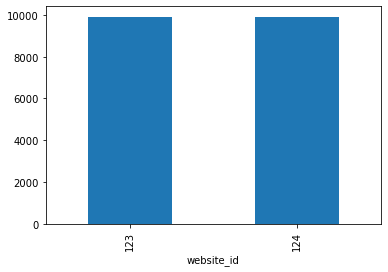

In [13]:
# From the dataset we already can tell website id belong to two different company
# Website_id = 123 is example.com and id = 124 is XYZ.com

# How many customers for each company?

df.groupby('website_id')['customer_id'].nunique().plot(kind='bar')
plt.show()

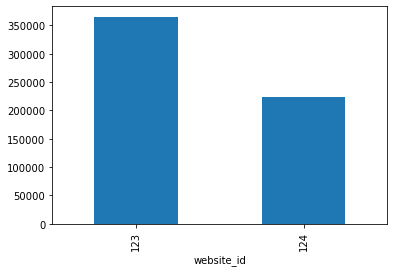

In [14]:
# What about the total sales for each company?

df.groupby('website_id')['checkout_amount'].sum().plot(kind='bar')
plt.show()

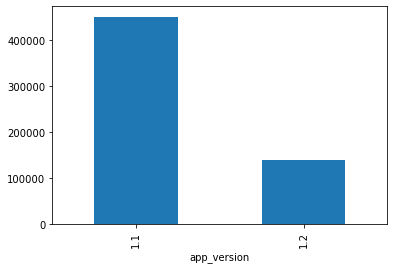

In [15]:
# What about total sales for each app_version?

df.groupby('app_version')['checkout_amount'].sum().plot(kind='bar')
plt.show()

From the above charts we have a slightly better understanding now. It seems there are only two companies (website_id) in this dataset. And one important note is there are two app_version 1.1 vs 1.2.
Let's dig in further...

In [16]:
# Add day and hour columns

df['day'] = df['time'].dt.day
df['hour'] = df['time'].dt.hour

df.head(10)

,website_id,customer_id,app_version,placeholder,checkout_amount,url,time,day,hour
0,124,9221,1.1,NaN,6,http://xyz.com/checkout?Bignay=1,2017-07-01 07:00:05,1,7
1,124,1639,1.1,NaN,6,http://xyz.com/checkout?Ume=1,2017-07-01 07:00:14,1,7
2,124,8272,1.1,NaN,6,http://xyz.com/checkout?Natal+Orange=1,2017-07-01 00:00:15,1,0
3,123,6921,1.1,NaN,6,http://www.example.com/store/?Natal+Orange=1,2017-07-01 00:00:18,1,0
4,124,9219,1.1,NaN,4,http://xyz.com/checkout?Hazelnut=1,2017-07-01 00:00:19,1,0
5,124,8451,1.1,NaN,7,http://xyz.com/checkout?Round+Kumquat=1,2017-07-01 00:00:28,1,0
6,124,6079,1.1,NaN,5,http://xyz.com/checkout?Ylang-ylang=1,2017-07-01 00:00:32,1,0
7,123,5267,1.1,NaN,5,http://www.example.com/store/?Black%2FWhite+Pe...,2017-07-01 07:00:34,1,7
8,123,10151,1.1,NaN,12,http://www.example.com/store/?Ume=1&Natal+Oran...,2017-07-01 07:00:37,1,7
9,124,4481,1.1,NaN,7,http://xyz.com/checkout?Round+Kumquat=1,2017-07-01 07:00:57,1,7


In [17]:
# The NaN in placeholder column seems to be related to app_verison 1.1

display(df)


,website_id,customer_id,app_version,placeholder,checkout_amount,url,time,day,hour
0,124,9221,1.1,NaN,6,http://xyz.com/checkout?Bignay=1,2017-07-01 07:00:05,1,7
1,124,1639,1.1,NaN,6,http://xyz.com/checkout?Ume=1,2017-07-01 07:00:14,1,7
2,124,8272,1.1,NaN,6,http://xyz.com/checkout?Natal+Orange=1,2017-07-01 00:00:15,1,0
3,123,6921,1.1,NaN,6,http://www.example.com/store/?Natal+Orange=1,2017-07-01 00:00:18,1,0
4,124,9219,1.1,NaN,4,http://xyz.com/checkout?Hazelnut=1,2017-07-01 00:00:19,1,0
...,...,...,...,...,...,...,...,...,...
9976,124,3158,1.2,new_version,6,http://xyz.com/checkout?Ume=1,2017-07-03 23:59:10,3,23
9977,124,11189,1.2,new_version,57,http://xyz.com/checkout?Hazelnut=2&Round+Kumqu...,2017-07-03 23:59:19,3,23
9978,124,7730,1.2,new_version,3,http://xyz.com/checkout?Prairie+Potato=1,2017-07-03 23:59:32,3,23
9979,124,8204,1.2,new_version,6,http://xyz.com/checkout?Ume=1,2017-07-03 23:59:34,3,23


In [18]:
# Replace NaN and also rename placeholder column to be "version" so it's more meaningful

df['placeholder'].fillna('old_version', inplace = True)
df.rename(columns = {'placeholder':'version'}, inplace = True)
df.head()

,website_id,customer_id,app_version,version,checkout_amount,url,time,day,hour
0,124,9221,1.1,old_version,6,http://xyz.com/checkout?Bignay=1,2017-07-01 07:00:05,1,7
1,124,1639,1.1,old_version,6,http://xyz.com/checkout?Ume=1,2017-07-01 07:00:14,1,7
2,124,8272,1.1,old_version,6,http://xyz.com/checkout?Natal+Orange=1,2017-07-01 00:00:15,1,0
3,123,6921,1.1,old_version,6,http://www.example.com/store/?Natal+Orange=1,2017-07-01 00:00:18,1,0
4,124,9219,1.1,old_version,4,http://xyz.com/checkout?Hazelnut=1,2017-07-01 00:00:19,1,0


Obviously for this dataset, checkout_amount column is very important. So let's take a closer look...

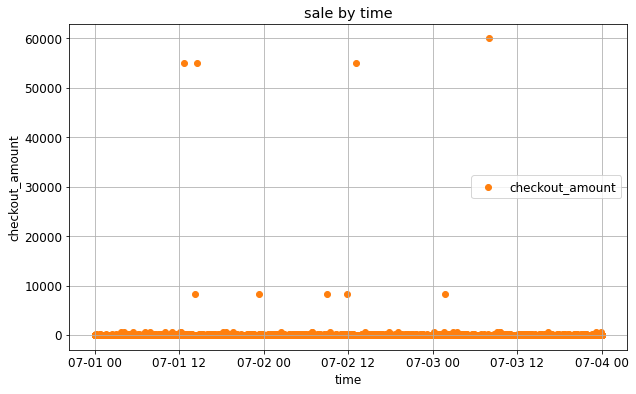

In [19]:
# Quick visulization on the checkout_amount column. It looks like there are a few outliers - all large transactions
# Most of sales are small amount but there are a few transaction in the ~$10000 and ~60000 range

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# scatter plot
ax.scatter(df.time, df.checkout_amount, color='tab:orange', label='checkout_amount')

# same as above
ax.set_xlabel('time')
ax.set_ylabel('checkout_amount')
ax.set_title('sale by time')
ax.grid(True)
ax.legend(loc='right');

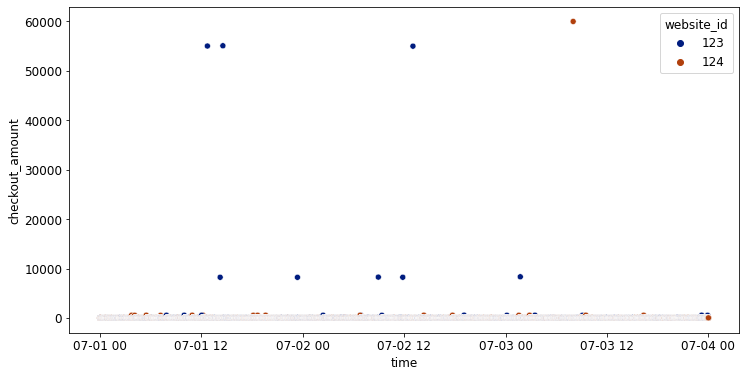

In [60]:
# Another way to look. It's interesting to see all the large transactions are from website_id = 123.
# And on 07-03 there is one large transaction (~$60000) on website_id = 124.
# Later on we will find this transaction has issue.

plt.figure(figsize=(12,6))
ax = sns.scatterplot(data=df, x="time", y="checkout_amount",  hue="website_id", palette = 'dark')

plt.show()

While these large transactions are important to sales. But we need to be very careful because it may significant change the distribution and eventually ML prediction.

We may want to remove these outliers from the main distribution because these large transaction is <0.03% of total transactions.

In [20]:
# Then if we look all the outliers it seems there might be a glitch on day3 when we introduced the new version. 
# The last transaction #3854 has an error (we can see details from the url column) and should be removed

outliers = df.loc[df['checkout_amount']> 5000]
outliers

,website_id,customer_id,app_version,version,checkout_amount,url,time,day,hour
2707,123,11613,1.1,old_version,55031,http://www.example.com/store/?Hazelnut=995&Ume...,2017-07-01 12:44:11,1,12
3493,123,11611,1.1,old_version,8225,http://www.example.com/store/?Hazelnut=174&Ume...,2017-07-01 14:14:34,1,14
3636,123,11613,1.1,old_version,55084,http://www.example.com/store/?Hazelnut=1015&Um...,2017-07-01 14:33:54,1,14
7920,123,11612,1.1,old_version,8219,http://www.example.com/store/?Hazelnut=159&Ume...,2017-07-01 23:23:12,1,23
2266,123,11611,1.1,old_version,8232,http://www.example.com/store/?Hazelnut=147&Ume...,2017-07-02 11:50:23,2,11
4193,123,11611,1.1,old_version,8262,http://www.example.com/store/?Hazelnut=163&Ume...,2017-07-02 08:57:09,2,8
6220,123,11613,1.1,old_version,55002,http://www.example.com/store/?Hazelnut=986&Ume...,2017-07-02 13:02:41,2,13
889,123,11612,1.1,old_version,8326,http://www.example.com/store/?Hazelnut=167&Ume...,2017-07-03 01:44:26,3,1
3854,124,8553,1.2,new_version,60000,http://xyz.com/checkout?Bignay=1&error=True,2017-07-03 07:59:32,3,7


In [21]:
# In fact, since there are only 9 large transactions out of ~30000 total sales. 
# We could treat them as outliers and remove all of them for now. 
# We will save it to a different dataframe df1 because we may still need the df (all sales).

df1 = df.drop(df[df['checkout_amount']> 5000].index)
df1.describe()

,website_id,customer_id,app_version,checkout_amount,day,hour
count,33161.000000,33161.000000,33161.000000,33161.000000,33161.000000,33161.000000
mean,123.501282,5803.109044,1.124671,9.720334,2.055638,11.923464
std,0.500006,3353.259701,0.043110,22.412772,0.805783,6.793756
min,123.000000,1.000000,1.100000,-12.000000,1.000000,0.000000
25%,123.000000,2895.000000,1.100000,5.000000,1.000000,6.000000
50%,124.000000,5796.000000,1.100000,6.000000,2.000000,12.000000
75%,124.000000,8706.000000,1.100000,7.000000,3.000000,18.000000
max,124.000000,11610.000000,1.200000,573.000000,3.000000,23.000000


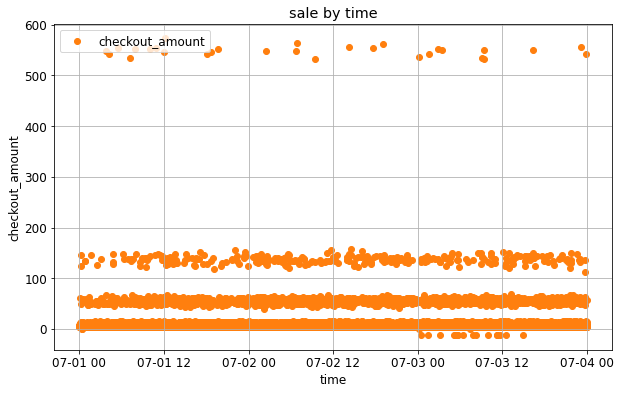

In [22]:
# quick visulization again to verify the checkout_amount distribution
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# scatter plot
ax.scatter(df1.time, df1.checkout_amount, color='tab:orange', label='checkout_amount')

# same as above
ax.set_xlabel('time')
ax.set_ylabel('checkout_amount')
ax.set_title('sale by time')
ax.grid(True)
ax.legend(loc='upper left');

Looks like there could be still other issue on day three. There a few transactions have negative values. Could this be refund? We will leave them for now...

<AxesSubplot:title={'center':'All Transactions'}, xlabel='day'>

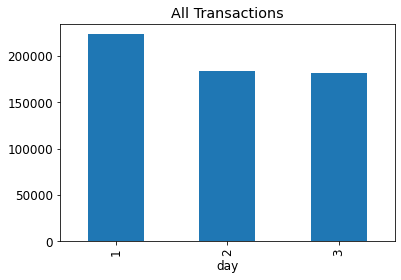

In [23]:
# if we compare the previous dataset without removing those large transaction then yes indeed day3 sale is smaller

df.groupby(['day'])['checkout_amount'].agg('sum').plot(kind='bar', title='All Transactions')


<AxesSubplot:title={'center':'Removing Large Transactions'}, xlabel='day'>

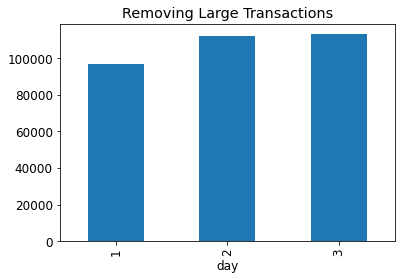

In [24]:
# However if we remove these large transactions then the sales are comparable or even increase a bit on day2 & 3.

df1.groupby(['day'])['checkout_amount'].agg('sum').plot(kind='bar', title='Removing Large Transactions')

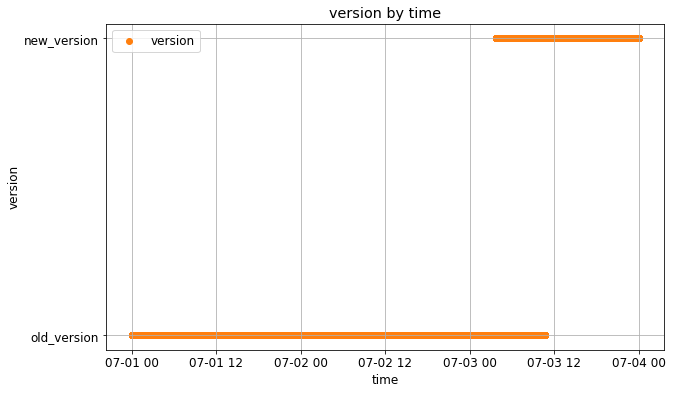

In [25]:
# Another quick visulization to understand when the new_version was introduced
# The new app version 1.2 was rolled out in early morning of 07-03 
# And the old version 1.1 was retired ~noon of 07-03 

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# scatter plot
ax.scatter(df1.time, df1.version, color='tab:orange', label='version')

# same as above
ax.set_xlabel('time')
ax.set_ylabel('version')
ax.set_title('version by time')
ax.grid(True)
ax.legend(loc='upper left');

### So in summary, based on these analysis, there could be multiple reasons why sale of 2017-07-03 is lower.
1. Most of the transactions are smaller sales but there is a few large sanscations on these three days. 4 on day1, 3 on day2 and 2 on day3.
2. Unfortunately, the 2nd large transaction on day 3 is wrong.
3. Interestingly this failed transaction is with new_version of app (version 1.2).
4. So there could be a glitch with new app or customer don't know how to use this new version of app.
5. Since we have only three days of data. It's hard to predict the trend of large transactions. But we need to closely watch for it as it may signficantly impact the total sales.
6. Finally if ignoring all large transactions (checkout_amount > $5000), then day 3 sale is not smaller comparing the previous 2 days.


### 4. More analysis on sale, customer, purchasing behavior

In this section we want to do more in depth analysis to gain better understanding on the dataset and or customer behavior...

In [26]:
df1.head()

,website_id,customer_id,app_version,version,checkout_amount,url,time,day,hour
0,124,9221,1.1,old_version,6,http://xyz.com/checkout?Bignay=1,2017-07-01 07:00:05,1,7
1,124,1639,1.1,old_version,6,http://xyz.com/checkout?Ume=1,2017-07-01 07:00:14,1,7
2,124,8272,1.1,old_version,6,http://xyz.com/checkout?Natal+Orange=1,2017-07-01 00:00:15,1,0
3,123,6921,1.1,old_version,6,http://www.example.com/store/?Natal+Orange=1,2017-07-01 00:00:18,1,0
4,124,9219,1.1,old_version,4,http://xyz.com/checkout?Hazelnut=1,2017-07-01 00:00:19,1,0


In [27]:
# We can calculate the average sale value per day. Day 3 is slightly lower than day 1 and day 2.

df2 = df1.groupby(['day'])['checkout_amount'].agg('sum')/df1.groupby(['day'])['url'].agg('count')
df2.head()


day
1    9.796644
2    9.734733
3    9.641878
dtype: float64

In [28]:
# If we break down by day and app version we could see the new version on day 3 has slight lower average transaction sale

df3 = df1.groupby(['day','version'])['checkout_amount'].agg('sum')/df1.groupby(['day','version'])['url'].agg('count')
df3.head()


day  version    
1    old_version    9.796644
2    old_version    9.734733
3    new_version    9.543699
     old_version    9.867622
dtype: float64

In [32]:
# We also want to generate another metric - number of transactions per hour for each day and app version
# This may provide better insight on customer behavior...

df1['day_hour'] = df1['day'].astype(str) + "_" + df1['hour'].astype(str)
df4 = df1.groupby(['day_hour','version']).agg(num_of_sales=('url','count')).reset_index()


df4.head(20)



,day_hour,version,num_of_sales
0,1_0,old_version,237
1,1_1,old_version,228
2,1_10,old_version,477
3,1_11,old_version,491
4,1_12,old_version,512
5,1_13,old_version,511
6,1_14,old_version,521
7,1_15,old_version,462
8,1_16,old_version,513
9,1_17,old_version,461


In [33]:
df4.tail(30)

,day_hour,version,num_of_sales
50,3_10,new_version,336
51,3_10,old_version,158
52,3_11,new_version,457
53,3_12,new_version,463
54,3_13,new_version,480
55,3_14,new_version,479
56,3_15,new_version,517
57,3_16,new_version,520
58,3_17,new_version,475
59,3_18,new_version,453


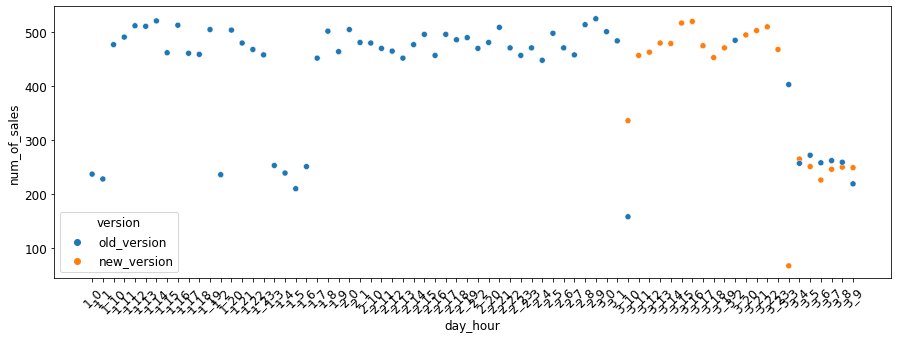

In [105]:
# From this chart we can see the pattern of user behavior. 
# Sometime the transaction is less during night/early morning (0~7am).
# And we rolled out the new verison on day 3 in the early morning.
# The num of transaction picking up on new version and then eventually fully migrated to new version.

plt.figure(figsize=(15,5))
ax = sns.scatterplot(data=df4, x="day_hour", y="num_of_sales",  hue="version")
plt.xticks(rotation=45)
plt.show()

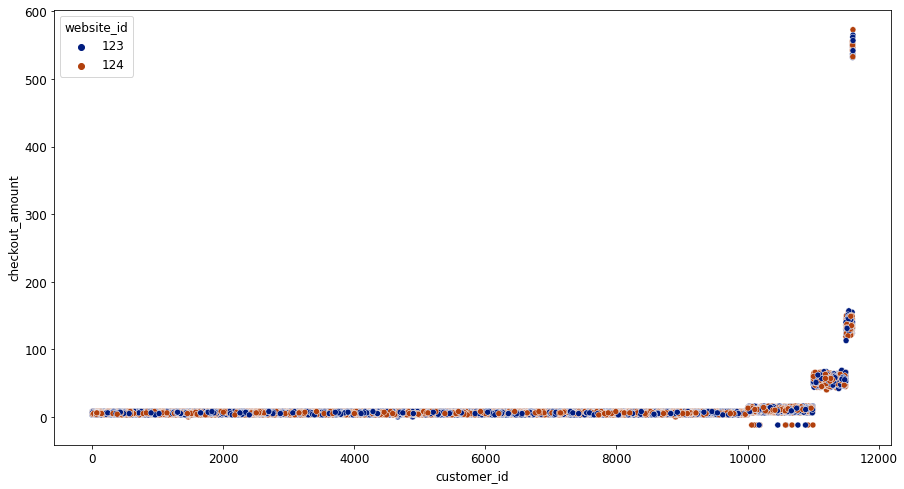

In [35]:
# It seems there is a pattern between customer_id vs sale values.
# The larger of customer_id, the more they could spend

plt.figure(figsize=(15,8))
sns.scatterplot(x = "customer_id", y = "checkout_amount", data = df1, hue = "website_id", palette = 'dark')

plt.show()

In [43]:
# From the checkout_amount and url columns, we can see these customers tend to purchase many items in combinations 

vip_customers = df1.loc[df1['customer_id']> 11000]

vip_customers

,website_id,customer_id,app_version,version,checkout_amount,url,time,day,hour,day_hour
23,124,11016,1.1,old_version,51,http://xyz.com/checkout?Hazelnut=1&Ume=1&Prair...,2017-07-01 07:03:40,1,7,1_7
32,123,11359,1.1,old_version,60,http://www.example.com/store/?Hazelnut=1&Ume=1...,2017-07-01 00:05:09,1,0,1_0
39,124,11393,1.1,old_version,51,http://xyz.com/checkout?Ume=1&Prairie+Potato=2...,2017-07-01 07:06:46,1,7,1_7
77,123,11597,1.1,old_version,124,http://www.example.com/store/?Hazelnut=5&Ume=2...,2017-07-01 00:11:38,1,0,1_0
79,124,11610,1.1,old_version,534,http://xyz.com/checkout?Hazelnut=9&Ume=8&Prair...,2017-07-01 07:11:47,1,7,1_7
...,...,...,...,...,...,...,...,...,...,...
9857,123,11483,1.2,new_version,55,http://store.example.com/?Hazelnut=1&Ume=2&Pra...,2017-07-03 23:26:55,3,23,3_23
9927,123,11504,1.2,new_version,113,http://store.example.com/?Hazelnut=6&Ume=4&Pra...,2017-07-03 23:48:02,3,23,3_23
9938,124,11476,1.2,new_version,47,http://xyz.com/checkout?Hazelnut=4&European+Gr...,2017-07-03 23:49:18,3,23,3_23
9951,124,11271,1.2,new_version,57,http://xyz.com/checkout?Prairie+Potato=1&Ylang...,2017-07-03 23:53:08,3,23,3_23


In [44]:
# Try to extract the information

vip_customers['product'] = vip_customers.url.str.extract(r'.*?\?(.*)\=.*')
vip_customers

,website_id,customer_id,app_version,version,checkout_amount,url,time,day,hour,day_hour,product
23,124,11016,1.1,old_version,51,http://xyz.com/checkout?Hazelnut=1&Ume=1&Prair...,2017-07-01 07:03:40,1,7,1_7,Hazelnut=1&Ume=1&Prairie+Potato=2&European+Gra...
32,123,11359,1.1,old_version,60,http://www.example.com/store/?Hazelnut=1&Ume=1...,2017-07-01 00:05:09,1,0,1_0,Hazelnut=1&Ume=1&Mabolo=3&European+Grape=2&Yla...
39,124,11393,1.1,old_version,51,http://xyz.com/checkout?Ume=1&Prairie+Potato=2...,2017-07-01 07:06:46,1,7,1_7,Ume=1&Prairie+Potato=2&Ylang-ylang=1&Mabolo=1&...
77,123,11597,1.1,old_version,124,http://www.example.com/store/?Hazelnut=5&Ume=2...,2017-07-01 00:11:38,1,0,1_0,Hazelnut=5&Ume=2&Prairie+Potato=4&Round+Kumqua...
79,124,11610,1.1,old_version,534,http://xyz.com/checkout?Hazelnut=9&Ume=8&Prair...,2017-07-01 07:11:47,1,7,1_7,Hazelnut=9&Ume=8&Prairie+Potato=14&Ylang-ylang...
...,...,...,...,...,...,...,...,...,...,...,...
9857,123,11483,1.2,new_version,55,http://store.example.com/?Hazelnut=1&Ume=2&Pra...,2017-07-03 23:26:55,3,23,3_23,Hazelnut=1&Ume=2&Prairie+Potato=1&European+Gra...
9927,123,11504,1.2,new_version,113,http://store.example.com/?Hazelnut=6&Ume=4&Pra...,2017-07-03 23:48:02,3,23,3_23,Hazelnut=6&Ume=4&Prairie+Potato=9&Mabolo=1&Rou...
9938,124,11476,1.2,new_version,47,http://xyz.com/checkout?Hazelnut=4&European+Gr...,2017-07-03 23:49:18,3,23,3_23,Hazelnut=4&European+Grape=2&Black%2FWhite+Pepp...
9951,124,11271,1.2,new_version,57,http://xyz.com/checkout?Prairie+Potato=1&Ylang...,2017-07-03 23:53:08,3,23,3_23,Prairie+Potato=1&Ylang-ylang=2&European+Grape=...


In [71]:
# Let's take a look on those 9 large transactions
# So it seems these are all bulk sales with many items and large qty

outliers['product'] = outliers.url.apply(lambda x: x.split('?')[1].split('='))
print(outliers['product'].to_markdown())

|      | product                                                                                                                                                                                             |
|-----:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 2707 | ['Hazelnut', '995&Ume', '981&Prairie+Potato', '1013&Mabolo', '1020&European+Grape', '976&Round+Kumquat', '1011&Black%2FWhite+Pepper', '1005&Ylang-ylang', '1010&Natal+Orange', '999&Bignay', '990'] |
| 3493 | ['Hazelnut', '174&Ume', '180&Prairie+Potato', '142&Mabolo', '146&European+Grape', '138&Round+Kumquat', '135&Black%2FWhite+Pepper', '140&Bignay', '140&Natal+Orange', '155&Ylang-ylang', '150']      |
| 3636 | ['Hazelnut', '1015&Ume', '998&Prairie+Potato', '983&Mabolo', '1059&Round+Kumquat', '963&European+Grape', '1011&Black%2FWhite+Pepper', '1049&Bignay', '999&Natal+Ora

In [73]:
# Like we have already find out, 8 out 9 large transactions are on website example.com
# The only one on website xyz is on 07-03 with new version 1.2 app and has some issue.

outliers.head(10)

,website_id,customer_id,app_version,version,checkout_amount,url,time,day,hour,product
2707,123,11613,1.1,old_version,55031,http://www.example.com/store/?Hazelnut=995&Ume...,2017-07-01 12:44:11,1,12,"[Hazelnut, 995&Ume, 981&Prairie+Potato, 1013&M..."
3493,123,11611,1.1,old_version,8225,http://www.example.com/store/?Hazelnut=174&Ume...,2017-07-01 14:14:34,1,14,"[Hazelnut, 174&Ume, 180&Prairie+Potato, 142&Ma..."
3636,123,11613,1.1,old_version,55084,http://www.example.com/store/?Hazelnut=1015&Um...,2017-07-01 14:33:54,1,14,"[Hazelnut, 1015&Ume, 998&Prairie+Potato, 983&M..."
7920,123,11612,1.1,old_version,8219,http://www.example.com/store/?Hazelnut=159&Ume...,2017-07-01 23:23:12,1,23,"[Hazelnut, 159&Ume, 151&Prairie+Potato, 143&Ma..."
2266,123,11611,1.1,old_version,8232,http://www.example.com/store/?Hazelnut=147&Ume...,2017-07-02 11:50:23,2,11,"[Hazelnut, 147&Ume, 143&Prairie+Potato, 153&Ma..."
4193,123,11611,1.1,old_version,8262,http://www.example.com/store/?Hazelnut=163&Ume...,2017-07-02 08:57:09,2,8,"[Hazelnut, 163&Ume, 145&Prairie+Potato, 156&Ma..."
6220,123,11613,1.1,old_version,55002,http://www.example.com/store/?Hazelnut=986&Ume...,2017-07-02 13:02:41,2,13,"[Hazelnut, 986&Ume, 1008&Prairie+Potato, 1012&..."
889,123,11612,1.1,old_version,8326,http://www.example.com/store/?Hazelnut=167&Ume...,2017-07-03 01:44:26,3,1,"[Hazelnut, 167&Ume, 160&Prairie+Potato, 130&Yl..."
3854,124,8553,1.2,new_version,60000,http://xyz.com/checkout?Bignay=1&error=True,2017-07-03 07:59:32,3,7,"[Bignay, 1&error, True]"


In [45]:
# Now go back to all dataset, trying to extract product and count

df1['product_count_tuple'] = df1.url.apply(lambda x: x.split('?')[1].split('='))
df1['product'] = df1.product_count_tuple.apply(lambda x: x[0].replace('+', ' '))
df1['count'] = df1.product_count_tuple.apply(lambda x: x[1])
df1 = df1.drop('product_count_tuple', 1)

df1.head(10)

,website_id,customer_id,app_version,version,checkout_amount,url,time,day,hour,day_hour,product,count
0,124,9221,1.1,old_version,6,http://xyz.com/checkout?Bignay=1,2017-07-01 07:00:05,1,7,1_7,Bignay,1
1,124,1639,1.1,old_version,6,http://xyz.com/checkout?Ume=1,2017-07-01 07:00:14,1,7,1_7,Ume,1
2,124,8272,1.1,old_version,6,http://xyz.com/checkout?Natal+Orange=1,2017-07-01 00:00:15,1,0,1_0,Natal Orange,1
3,123,6921,1.1,old_version,6,http://www.example.com/store/?Natal+Orange=1,2017-07-01 00:00:18,1,0,1_0,Natal Orange,1
4,124,9219,1.1,old_version,4,http://xyz.com/checkout?Hazelnut=1,2017-07-01 00:00:19,1,0,1_0,Hazelnut,1
5,124,8451,1.1,old_version,7,http://xyz.com/checkout?Round+Kumquat=1,2017-07-01 00:00:28,1,0,1_0,Round Kumquat,1
6,124,6079,1.1,old_version,5,http://xyz.com/checkout?Ylang-ylang=1,2017-07-01 00:00:32,1,0,1_0,Ylang-ylang,1
7,123,5267,1.1,old_version,5,http://www.example.com/store/?Black%2FWhite+Pe...,2017-07-01 07:00:34,1,7,1_7,Black%2FWhite Pepper,1
8,123,10151,1.1,old_version,12,http://www.example.com/store/?Ume=1&Natal+Oran...,2017-07-01 07:00:37,1,7,1_7,Ume,1&Natal+Orange
9,124,4481,1.1,old_version,7,http://xyz.com/checkout?Round+Kumquat=1,2017-07-01 07:00:57,1,7,1_7,Round Kumquat,1


In [47]:
# Calculate product price

df1['count'] = pd.to_numeric(df1['count'], errors = 'coerce')

df1['product price'] = df1['checkout_amount']/df1['count']

df1.head(10)



,website_id,customer_id,app_version,version,checkout_amount,url,time,day,hour,day_hour,product,count,product price
0,124,9221,1.1,old_version,6,http://xyz.com/checkout?Bignay=1,2017-07-01 07:00:05,1,7,1_7,Bignay,1.0,6.0
1,124,1639,1.1,old_version,6,http://xyz.com/checkout?Ume=1,2017-07-01 07:00:14,1,7,1_7,Ume,1.0,6.0
2,124,8272,1.1,old_version,6,http://xyz.com/checkout?Natal+Orange=1,2017-07-01 00:00:15,1,0,1_0,Natal Orange,1.0,6.0
3,123,6921,1.1,old_version,6,http://www.example.com/store/?Natal+Orange=1,2017-07-01 00:00:18,1,0,1_0,Natal Orange,1.0,6.0
4,124,9219,1.1,old_version,4,http://xyz.com/checkout?Hazelnut=1,2017-07-01 00:00:19,1,0,1_0,Hazelnut,1.0,4.0
5,124,8451,1.1,old_version,7,http://xyz.com/checkout?Round+Kumquat=1,2017-07-01 00:00:28,1,0,1_0,Round Kumquat,1.0,7.0
6,124,6079,1.1,old_version,5,http://xyz.com/checkout?Ylang-ylang=1,2017-07-01 00:00:32,1,0,1_0,Ylang-ylang,1.0,5.0
7,123,5267,1.1,old_version,5,http://www.example.com/store/?Black%2FWhite+Pe...,2017-07-01 07:00:34,1,7,1_7,Black%2FWhite Pepper,1.0,5.0
8,123,10151,1.1,old_version,12,http://www.example.com/store/?Ume=1&Natal+Oran...,2017-07-01 07:00:37,1,7,1_7,Ume,NaN,NaN
9,124,4481,1.1,old_version,7,http://xyz.com/checkout?Round+Kumquat=1,2017-07-01 07:00:57,1,7,1_7,Round Kumquat,1.0,7.0


### 5. Prediction of 07-04 sale value



Two models will be developed. The first model is without large transactions. The 2nd model is with large transactions.

In [48]:
# The 1st model is without larget transaction so we will use df1

df5 = df1[['website_id','version','checkout_amount','day']]
df5.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 33161 entries, 0 to 9980
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   website_id       33161 non-null  int64 
 1   version          33161 non-null  object
 2   checkout_amount  33161 non-null  int64 
 3   day              33161 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 2.3+ MB


In [49]:
df5.head()

,website_id,version,checkout_amount,day
0,124,old_version,6,1
1,124,old_version,6,1
2,124,old_version,6,1
3,123,old_version,6,1
4,124,old_version,4,1


In [50]:
# Since we only have one data point on new_version on day 3. We will not include version feature in the model

data1 = df5.groupby(['day'])['checkout_amount'].agg('sum').reset_index()
data1.head()


,day,checkout_amount
0,1,96928
1,2,112222
2,3,113186


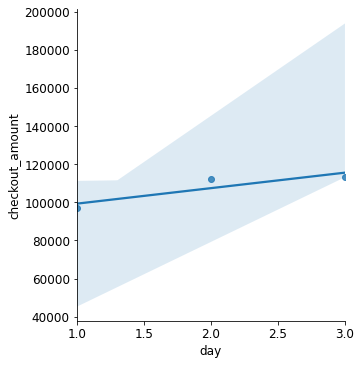

In [51]:
# A quick chart

sns.lmplot(x='day',y='checkout_amount',data=data1,fit_reg=True)

In [53]:
# A very simple linear regression model

from sklearn.linear_model import LinearRegression

X1 = data1['day'].values.reshape(-1, 1)
y1 = data1['checkout_amount'].values.reshape(-1, 1)
reg1 = LinearRegression().fit(X1, y1)
Y_pred1 = reg1.predict(X1)


print("The model1's regression score is:", reg1.score(X1, y1))
print("The model1's coefficient is:", reg1.coef_)
print("The model1's intercept is: ", reg1.intercept_)

print("The model1's predicted 07-04 sale is:", reg1.predict([[4]]))

The model1's regression score is: 0.7943048311071248
The model1's coefficient is: [[8129.]]
The model1's intercept is:  [91187.33333333]
The model1's predicted 07-04 sale is: [[123703.33333333]]


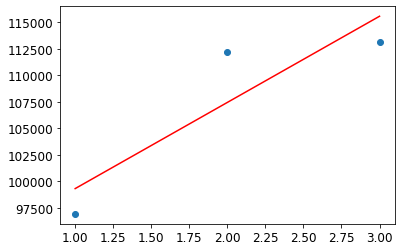

In [54]:
# Here is a visual on the model1

plt.scatter(X1, y1)
plt.plot(X1, Y_pred1, color='red')
plt.show()

In [55]:
# The 2nd model is with larget transaction so we will use dataframe df

df6 = df[['website_id','version','checkout_amount','day']]
df6.head()


,website_id,version,checkout_amount,day
0,124,old_version,6,1
1,124,old_version,6,1
2,124,old_version,6,1
3,123,old_version,6,1
4,124,old_version,4,1


In [56]:
data2 = df6.groupby(['day'])['checkout_amount'].agg('sum').reset_index()
data2.head()


,day,checkout_amount
0,1,223515
1,2,183752
2,3,181583


In [57]:
# 2nd linear regression model

X2 = data2['day'].values.reshape(-1, 1)
y2 = data2['checkout_amount'].values.reshape(-1, 1)
reg2 = LinearRegression().fit(X2, y2)
Y_pred2 = reg2.predict(X2)


print("The model2's regression score is:", reg2.score(X2, y2))
print("The model2's coefficient is:", reg2.coef_)
print("The model2's intercept is: ", reg2.intercept_)

print("The model2's predicted 07-04 sale is:", reg2.predict([[4]]))

The model2's regression score is: 0.7886857981537082
The model2's coefficient is: [[-20966.]]
The model2's intercept is:  [238215.33333333]
The model2's predicted 07-04 sale is: [[154351.33333333]]


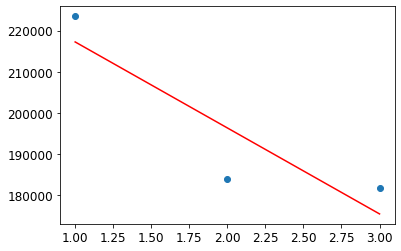

In [58]:
# Here is a visual on the model2

plt.scatter(X2, y2)
plt.plot(X2, Y_pred2, color='red')
plt.show()

It's interesting to see different prediction trend between Model1 (without large transaction) and Model2 (with large transaction). Like what we have already highlighted in the previous analysis, there are only a very small number of large transaction per day and it varies by day which will greatly impact the total sale per day. And also one large transactions on day3 with new app_feature has issue so should be removed. 

### ML Model Takeaway

This is a very simple linear regression model. Since we only have several datapoints so the model prediction may not be very accurate. 

Generally speaking there are several assumption to use a linear regression
1. There is a linear relationship between x and y.
2. All variables are normal distribution.
3. There is no or little multicollinearity.
4. No auto-correlation.
5. Homoscedasticity, meaning the residuals are equal across the regression line.

Since we only have a few data point to predict the total sale number for 07-04. Not all the assumptions are met. So the final prediction might not be accurate.



#### Last point, it's also worthy to mention that July-4th is US holiday. So customers' behavior might be signficantly different during holiday. This factor need also be considered as well but currently not presented in this model prediction.

### 6. Final words 

The fundamental challenge for this ML model is the limit amount of data. We only have three days' worth of data which is not enough, espeically for time series ML prediction work. And we should try to collect more data to check the pattern, seasonality etc. Ideally if we have several months or one year of data we could do better predicition (including holidays for example).

Besides the limit number of observations, it would be also great if we could collect addition features like user demographic data (age, gender, education, income etc.) and other transaction data (credit/debit, purchase/return etc).

Lastly, there are more work could be done to understand the customer purchase combination, event and behavior if we have more time.


# Thank you!